In [49]:
import numpy as np

# Init params

# Zadoff-Chu sequence params
# Length of sequence
N = 12
# Root index of sequence
r = 1

# Channel params
# Period of chip
T_c = 2
# Length sequence for chip
Nc = N
# Period of 
T_0 = T_c / 8
# Base frequnecy
f0 = 1 / T_0
# Sampling frequency / time step
dt = T_0 / 20
# Maximum possible number of sequences
tmpRe = int(T_c / dt)
tmpIm = int(T_c / dt)
# Signal duration
Ts = Nc * T_c
# Random phase shift
tetta = 2

# Timeline
t = np.arange(0, Ts, dt)

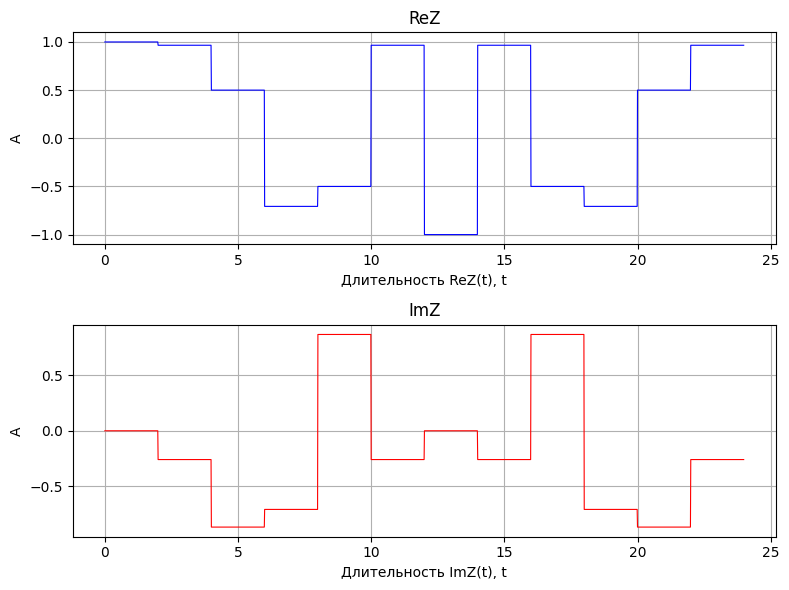

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import sdr

# Generate ZC-sequence
S1 = sdr.zadoff_chu_sequence(N, r)

# Phi functions
phi1 = lambda t: np.where((0 < t) & (t < np.sqrt(T_c)), (1 / T_c), 0)
phi2 = lambda t: np.where((0 < t) & (t < np.sqrt(T_c)), (1 / T_c), 0)

# Piecewise constant functions
ReZ = lambda t: np.sum([S1[n].real * phi1(t - n*T_c) for n in range(N)], axis=0)
ImZ = lambda t: np.sum([S1[n].imag * phi1(t - n*T_c) for n in range(N)], axis=0)

# Преобразуем матрицы в вектора
ReZ_values_reverse = np.repeat(S1.real, tmpRe)
ImZ_values_reverse = np.repeat(S1.imag, tmpIm)
ReZ_values = np.repeat(S1.real, tmpRe)
ImZ_values = np.repeat(S1.imag, tmpIm)



plt.figure(figsize=(8, 6))

# График ReZ_values
plt.subplot(2, 1, 1)
plt.plot(t, ReZ_values, color='blue', linewidth=0.8)
plt.title('ReZ')
plt.xlabel('Длительность ReZ(t), t')
plt.ylabel('A')
plt.grid(True)

# График ImZ_values
plt.subplot(2, 1, 2)
plt.plot(t, ImZ_values, color='red', linewidth=0.8)
plt.title('ImZ')
plt.xlabel('Длительность ImZ(t), t')
plt.ylabel('A')
plt.grid(True)

plt.tight_layout()
plt.show()

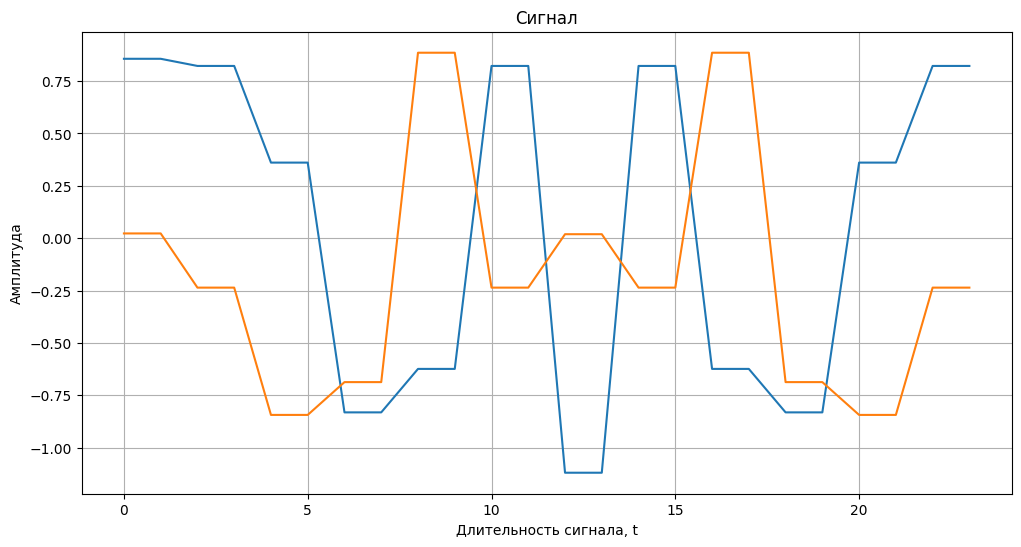

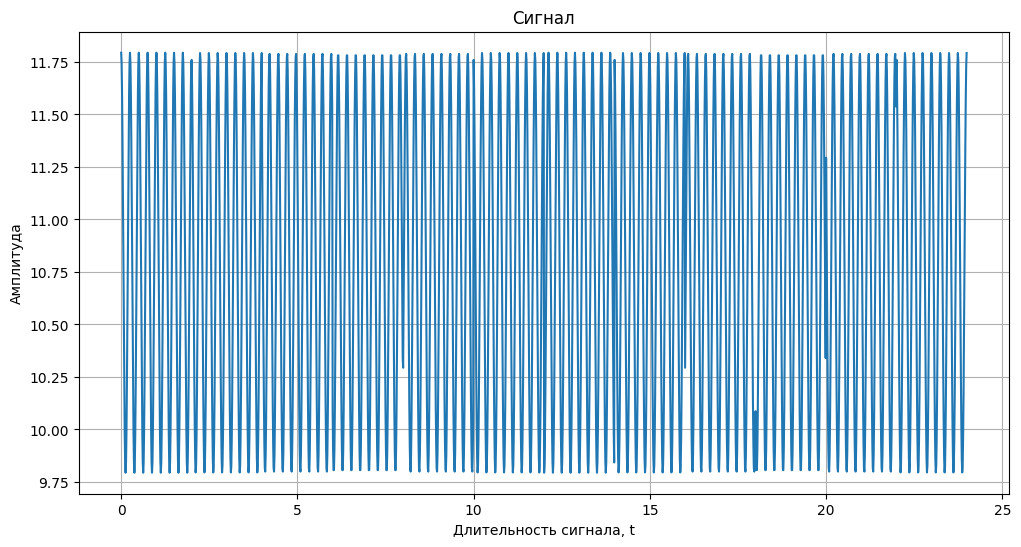

In [91]:
import matplotlib.pyplot as plt

# Построение сигнала
Stz = ReZ_values * np.cos(2 * np.pi * f0 * t) + ImZ_values * np.sin(2 * np.pi * f0 * t) + np.random.random() * 20
# Сдвинутый сигнал

reverse_sin = Stz * np.cos(2 * np.pi * f0 * t)
reverse_cos = Stz * np.sin(2 * np.pi * f0 * t)

plt.figure(figsize=(12, 6))
plt.plot(t, Stz)
plt.title('Сигнал')
plt.xlabel('Длительность сигнала, t')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.show()

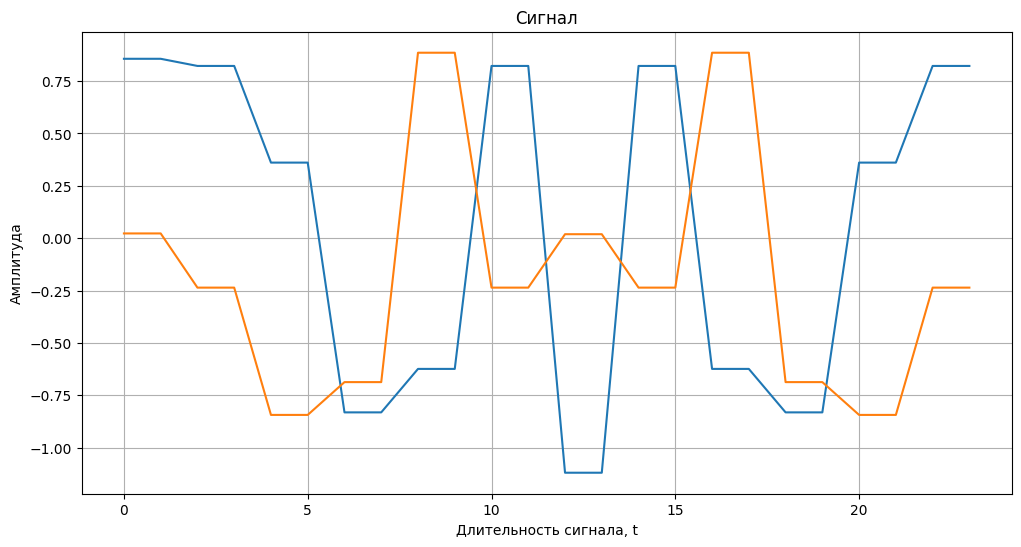

In [92]:
interval_re = []
interval_im = []

for i in range(N):
  integral_reverse_sin = np.trapz(reverse_sin[i*tmpRe:i*tmpRe + tmpRe], x=t[i:i + tmpRe])
  integral_reverse_cos = np.trapz(reverse_cos[i*tmpIm:i*tmpIm + tmpIm], x=t[i:i + tmpIm])
  interval_re.append(integral_reverse_sin)
  interval_im.append(integral_reverse_cos)

plt.figure(figsize=(12, 6))
plt.plot(np.repeat(interval_re, 2))
plt.plot(np.repeat(interval_im, 2))
plt.title('Сигнал')
plt.xlabel('Длительность сигнала, t')
plt.ylabel('Амплитуда')
plt.grid(True)